<a href="https://colab.research.google.com/github/100496072/APRENDIZAJE_2/blob/main/03_CLUSTERING_100496633_100496072.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

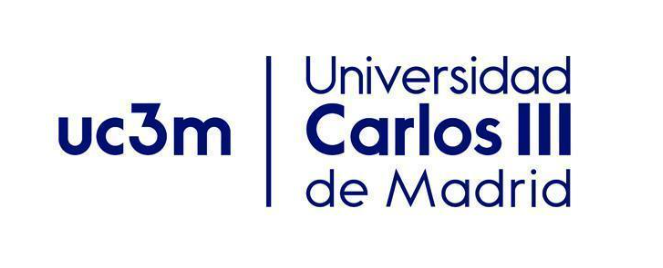

#  EDA SIMPLIFICADO

In [ ]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib import style
import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as sch
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


warnings.filterwarnings('ignore')
style.use('ggplot') or plt.style.use('ggplot')

In [ ]:
df = pd.read_csv("semillas.csv")

#Todas las features del dataset
print(f" Keys: {df.keys()}\n")

# Obtener el número de filas y columnas
rows, columns = df.shape
print("📊 DataFrame Overview")
print(f"🔹 Filas: {rows}")
print(f"🔹 Columnas: {columns}\n")

# Mostrar los tipos de las características
print("📝 Tipos de las Features:\n")
for columna in df.columns:
    print(f"   - {columna}: {df[columna].dtype}")

# Mostrar la cardinalidad de todas las columnas
print("\n🔍 Cardinalidad de las Features:\n")
for columna in df.columns:
    print(f"   - {columna}: {df[columna].nunique()} valores únicos")


X = df.drop(columns=["clase"])
y = df["clase"]

 Keys: Index(['area', 'perimetro', 'compacidad', 'longitud', 'anchura', 'asimetria',
       'surco', 'clase'],
      dtype='object')

📊 DataFrame Overview
🔹 Filas: 210
🔹 Columnas: 8

📝 Tipos de las Features:

   - area: float64
   - perimetro: float64
   - compacidad: float64
   - longitud: float64
   - anchura: float64
   - asimetria: float64
   - surco: float64
   - clase: int64

🔍 Cardinalidad de las Features:

   - area: 193 valores únicos
   - perimetro: 170 valores únicos
   - compacidad: 186 valores únicos
   - longitud: 188 valores únicos
   - anchura: 184 valores únicos
   - asimetria: 207 valores únicos
   - surco: 148 valores únicos
   - clase: 3 valores únicos


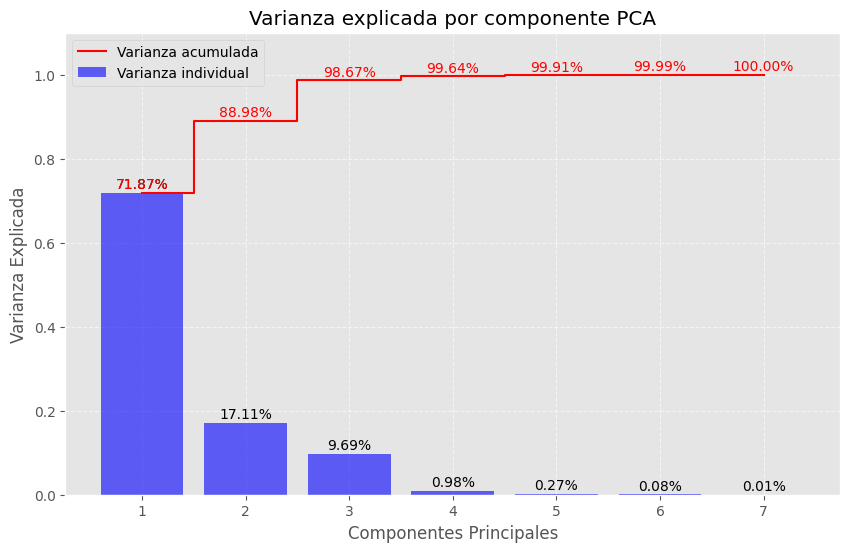

In [ ]:
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Siempre escalar antes de PCA
    ('pca', PCA())
])

# Ajustar y transformar
X_reduced = pipeline.fit_transform(X)
pca = pipeline.named_steps['pca']

# Varianza explicada y acumulada
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# 1. Plot de Varianza Explicada y Acumulada
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, label='Varianza individual', color='blue')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Varianza acumulada', color='red')

# Añadir valores exactos
for i, (ev, cv) in enumerate(zip(explained_variance, cumulative_variance)):
    plt.text(i + 1, ev + 0.01, f"{ev:.2%}", ha='center')
    plt.text(i + 1, cv + 0.01, f"{cv:.2%}", ha='center', color='red')

plt.xlabel('Componentes Principales')
plt.ylabel('Varianza Explicada')
plt.title('Varianza explicada por componente PCA')
plt.legend(loc='best')
plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Podemos observar que con 3 componentes se explica el 99% de la varianza aunque, a continuación y siguiendo las instrucciones del enunciado, usaremos 2 componenetes que explicará el 88% de la varianza perdiendo algo de información. De cara a hacer una representación y de entender los datos visualmente, es más sencilla una reproducción en 2 dimensiones, por ello solo se cogen 2 features.

# COMPROBACIÓN VISUAL DE LOS 3 MÉTODOS SCALERS

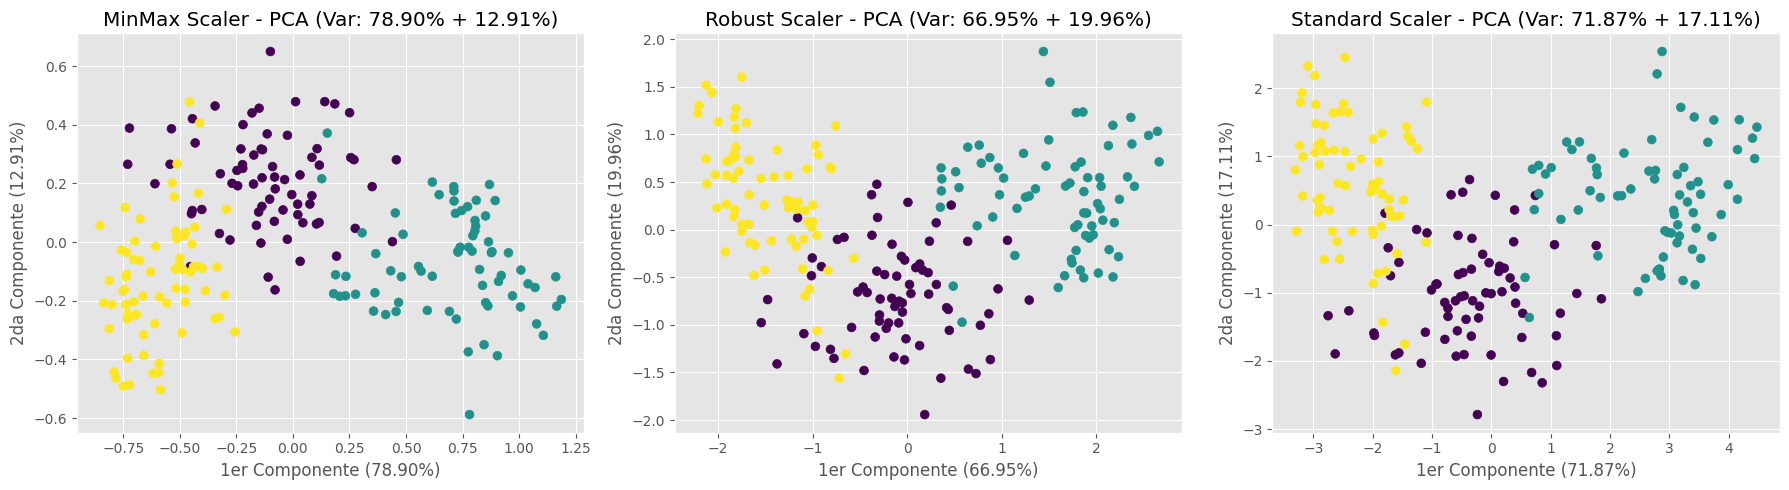

In [ ]:
# Definir pipelines con diferentes escaladores

pipeline_minmax = Pipeline([
    ('scaler', MinMaxScaler()),
    ('pca', PCA(n_components=2))
])

pipeline_robust = Pipeline([
    ('scaler', RobustScaler()),
    ('pca', PCA(n_components=2))
])

pipeline_standar = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])


# Aplicar PCA con diferentes escaladores

X_reduced_minmax = pipeline_minmax.fit_transform(X)
pca_minmax = pipeline_minmax.named_steps['pca']
explained_variance_minmax = pca_minmax.explained_variance_ratio_

X_reduced_robust = pipeline_robust.fit_transform(X)
pca_robust = pipeline_robust.named_steps['pca']
explained_variance_robust = pca_robust.explained_variance_ratio_

X_reduced_standar = pipeline_standar.fit_transform(X)
pca_standar = pipeline_standar.named_steps['pca']
explained_variance_standar = pca_standar.explained_variance_ratio_

# Graficar resultados
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
cmap = 'viridis'


# MinMax Scaler
axes[0].scatter(X_reduced_minmax[:, 0], X_reduced_minmax[:, 1], c=y, s=40, cmap=cmap)
axes[0].set_title('MinMax Scaler - PCA (Var: {:.2%} + {:.2%})'.format(explained_variance_minmax[0], explained_variance_minmax[1]))
axes[0].set_xlabel('1er Componente ({:.2%})'.format(explained_variance_minmax[0]))
axes[0].set_ylabel('2da Componente ({:.2%})'.format(explained_variance_minmax[1]))

# Robust Scaler
axes[1].scatter(X_reduced_robust[:, 0], X_reduced_robust[:, 1], c=y, s=40, cmap=cmap)
axes[1].set_title('Robust Scaler - PCA (Var: {:.2%} + {:.2%})'.format(explained_variance_robust[0], explained_variance_robust[1]))
axes[1].set_xlabel('1er Componente ({:.2%})'.format(explained_variance_robust[0]))
axes[1].set_ylabel('2da Componente ({:.2%})'.format(explained_variance_robust[1]))

# Standard Scaler
axes[2].scatter(X_reduced_standar[:, 0], X_reduced_standar[:, 1], c=y, s=40, cmap=cmap)
axes[2].set_title('Standard Scaler - PCA (Var: {:.2%} + {:.2%})'.format(explained_variance_standar[0], explained_variance_standar[1]))
axes[2].set_xlabel('1er Componente ({:.2%})'.format(explained_variance_standar[0]))
axes[2].set_ylabel('2da Componente ({:.2%})'.format(explained_variance_standar[1]))

# Ajustar layout
plt.tight_layout()
plt.show()

Para esta parte hemos seguido el tutorial de clustering ofrecido por el profesorado para sacar las conclusiones.

Y como podemos observar, a diferencia de la primera práctica donde el mejor escaler era 'Robust Scaler', aqui podemos observar que el mejor scaler es 'MinMax Scaler' ya que tiene la mejor separación y agrupación de los datos

In [ ]:
#Elegimos el mejor escaler

X_scaled = X_reduced_minmax

#TÉCNICA DE CLUSTERING: K-MEANS

## K-MEANS CON 3 CLUSTERS

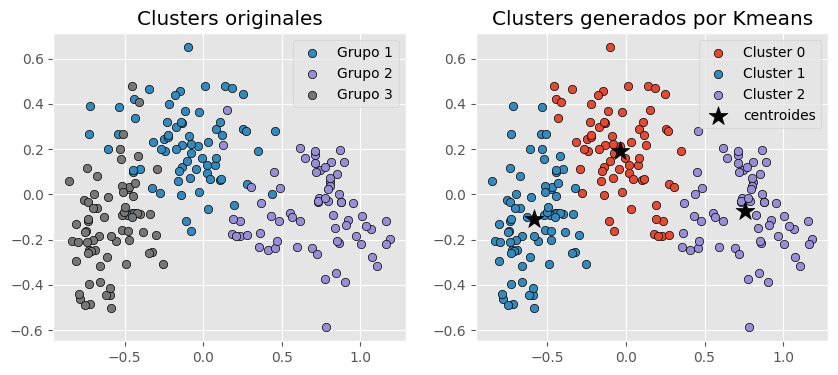

In [ ]:
KMeans_Omision = KMeans(
    n_clusters = 3,
    init = 'k-means++',
    n_init = 20,
    random_state = 100496072
)

KMeans_Omision.fit(X_scaled)
y_predict = KMeans_Omision.predict(X_scaled)



# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

# Grupos originales
for i in np.unique(y):
    ax[0].scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax[0].set_title('Clusters originales')
ax[0].legend();

for i in np.unique(y_predict):
    ax[1].scatter(
        x = X_scaled[y_predict == i, 0],
        y = X_scaled[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax[1].scatter(
    x = KMeans_Omision.cluster_centers_[:, 0],
    y = KMeans_Omision.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'centroides'
)
ax[1].set_title('Clusters generados por Kmeans')
ax[1].legend();

## ANÁLISIS HIPER-PARÁMETROS K-MEANS: MÉTODO DEL CODO

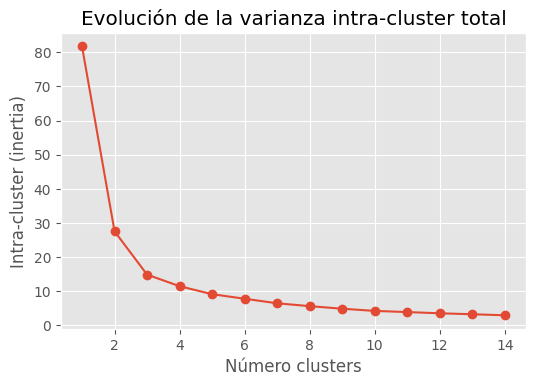

In [ ]:
inertias = []

for k in range(1,15):
    modelo_kmeans = KMeans(
        n_clusters   = k,
        n_init       = 20,
        random_state = 100496072
    )
    modelo_kmeans.fit(X_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range(1,15), inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

En la gráfica podemos visualizar que el punto que representa mejor el punto de "codo" es con K = 3 o K = 2.

## ANÁLISIS HIPER-PARÁMETROS K-MEANS: MÉTODO SILHOUETTE

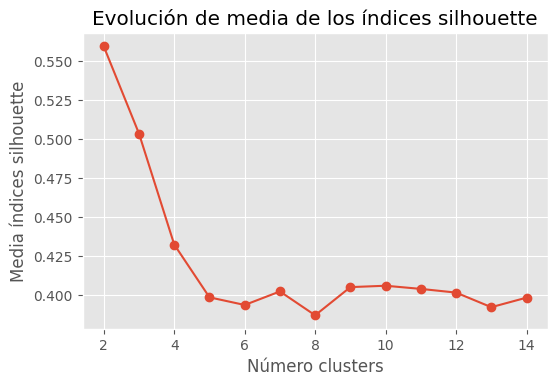

In [ ]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
valores_medios_silhouette = []

for k in range(2,15):
    modelo_kmeans = KMeans(
        n_clusters   = k,
        n_init       = 20,
        random_state = 100496072
    )
    cluster_labels = modelo_kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range(2,15), valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

En este caso, es mucho más facil determinar cuál es el valor óptimo para n_clusters. Al igual que en el anterior método el valor más óptimo es K = 2.

## K-MEANS CON K AJUSTADO

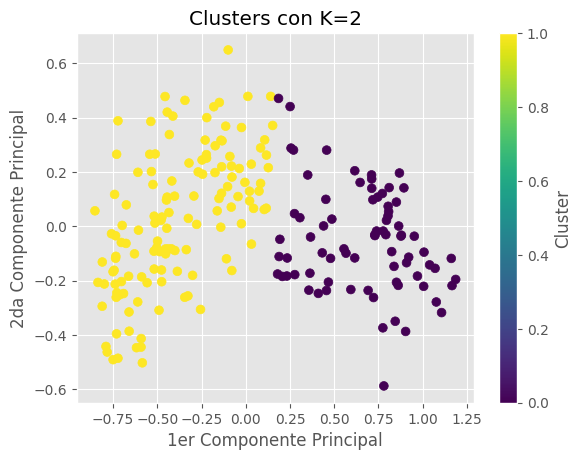

In [ ]:
# Entrenar el modelo con el mejor k
KMeans_Ajuste = KMeans(
    n_clusters = 2,
    init = 'k-means++',
    n_init = 20,
    random_state = 100496072
)

KMeans_Ajuste.fit(X_scaled)
y_predict = KMeans_Ajuste.predict(X_scaled)

# Visualizar los clusters en un gráfico 2D (si tienes PCA aplicado)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_predict, cmap='viridis', s=40)
plt.title(f'Clusters con K={2}')
plt.xlabel('1er Componente Principal')
plt.ylabel('2da Componente Principal')
plt.colorbar(label='Cluster')
plt.show()

Como podemos observar, originalmente nuestro problema tenía 3 clusters pero tras hacer K-Means con ajuste de hiperparámetros la opción que nos sale es un modelo con 2 clusters.

Como podemos observar en el dibujo se hace una separacion de los datos prácticamente a la mitad y a diferencia del modelo original, se puede observar que no hay ningún dato en la zona de un cluster diferente al suyo, por lo que tiene pinta de estar mejor agrupado.

#TÉCNICA DE CLUSTERING: CLUSTER-JERÁRQUICO

## ANÁLISIS DE DIFERENTES FUNCIONES LINKAGE

In [ ]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

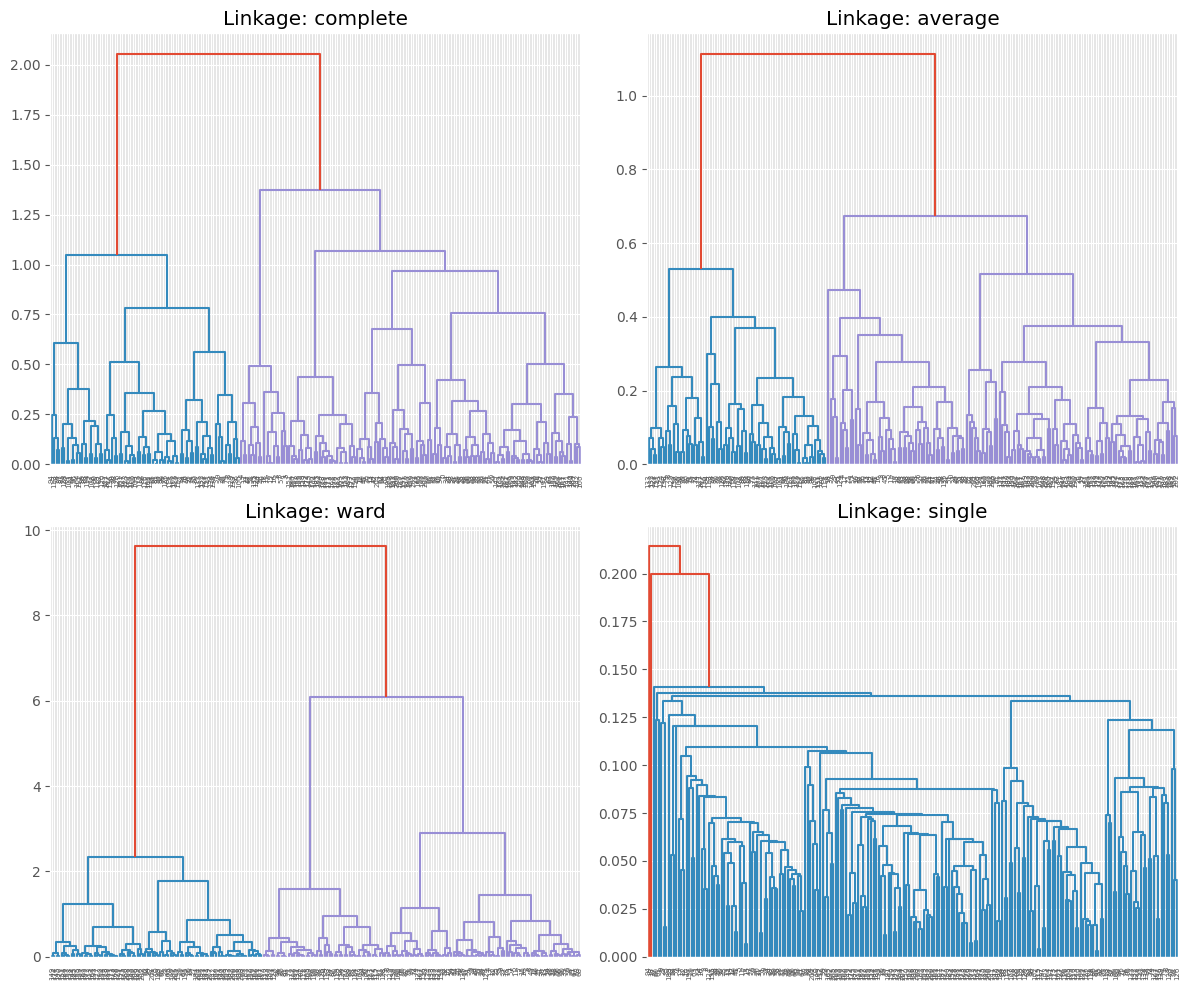

In [ ]:
# Modelos
# ==============================================================================
modelo_hclust_complete = AgglomerativeClustering(
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_complete.fit(X_scaled)

modelo_hclust_average = AgglomerativeClustering(
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X_scaled)

modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X_scaled)


modelo_hclust_single = AgglomerativeClustering(
    linkage  = 'single',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_single.fit(X_scaled)

linkages = ['complete', 'average', 'ward', 'single']
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

for ax, linkage in zip(axs.flat, linkages):
    Z = sch.linkage(X_scaled, method=linkage)
    sch.dendrogram(Z, ax=ax)
    ax.set_title(f'Linkage: {linkage}')

plt.tight_layout()
plt.show()

Con una rápida observación podemos observar que los linkage que mejor agrupan los datos son 'complete' y 'average' y el peror 'single', aunque, de todas formas, evaluaremos a las 4 funciones de linkage para saber cual es el valor óptimo de K para las 4.

## AJUSTE DE HIPERPARÁMETROS CLUSTER-JERÁRQUICO

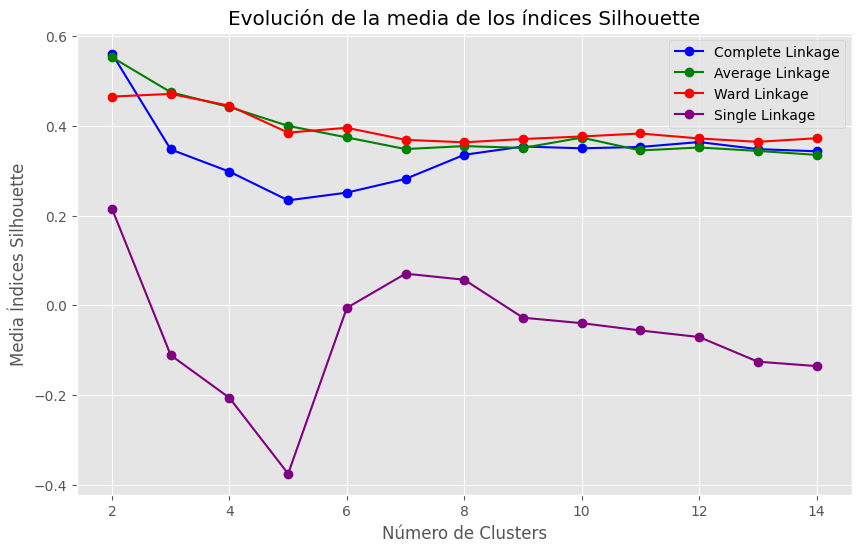

In [ ]:
# Listas para almacenar los valores de Silhouette Score para los 4 métodos de linkage
valores_medios_silhouette_complete = []
valores_medios_silhouette_average = []
valores_medios_silhouette_ward = []
valores_medios_silhouette_single = []

# Calcular la Silhouette Score para los 4 métodos de linkage
for k in range(2, 15):
    # Para el linkage 'complete'
    modelo_complete = AgglomerativeClustering(
        linkage='complete',
        n_clusters=k
    )
    cluster_labels_complete = modelo_complete.fit_predict(X_scaled)
    silhouette_avg_complete = silhouette_score(X_scaled, cluster_labels_complete)
    valores_medios_silhouette_complete.append(silhouette_avg_complete)

    # Para el linkage 'average'
    modelo_average = AgglomerativeClustering(
        linkage='average',
        n_clusters=k
    )
    cluster_labels_average = modelo_average.fit_predict(X_scaled)
    silhouette_avg_average = silhouette_score(X_scaled, cluster_labels_average)
    valores_medios_silhouette_average.append(silhouette_avg_average)

    # Para el linkage 'ward'
    modelo_ward = AgglomerativeClustering(
        linkage='ward',
        n_clusters=k
    )
    cluster_labels_ward = modelo_ward.fit_predict(X_scaled)
    silhouette_avg_ward = silhouette_score(X_scaled, cluster_labels_ward)
    valores_medios_silhouette_ward.append(silhouette_avg_ward)

    # Para el linkage 'single'
    modelo_single = AgglomerativeClustering(
        linkage='single',
        n_clusters=k
    )
    cluster_labels_single = modelo_single.fit_predict(X_scaled)
    silhouette_avg_single = silhouette_score(X_scaled, cluster_labels_single)
    valores_medios_silhouette_single.append(silhouette_avg_single)

# Crear la gráfica comparativa
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Graficar los resultados
ax.plot(range(2, 15), valores_medios_silhouette_complete, marker='o', label='Complete Linkage', color='b')
ax.plot(range(2, 15), valores_medios_silhouette_average, marker='o', label='Average Linkage', color='g')
ax.plot(range(2, 15), valores_medios_silhouette_ward, marker='o', label='Ward Linkage', color='r')
ax.plot(range(2, 15), valores_medios_silhouette_single, marker='o', label='Single Linkage', color='purple')

# Configuración de la gráfica
ax.set_title("Evolución de la media de los índices Silhouette")
ax.set_xlabel('Número de Clusters')
ax.set_ylabel('Media Índices Silhouette')
ax.legend()
ax.grid(True)

# Mostrar la gráfica
plt.show()


Como anticipábamos 'single' es la que peor funciona de todas las funciones.

Podemos observar que para 'single', 'complete' y 'average' el valor óptimo es K = 2 mientras que para 'ward' el valor óptimo es K = 3.

Finalmente elegiremos 'complete' con K = 2 ya que es la que mejor resultados da siendo un poco mejor que 'average'

## CLUSTER-JERÁRQUICO CON COMPLETE LINKAGE

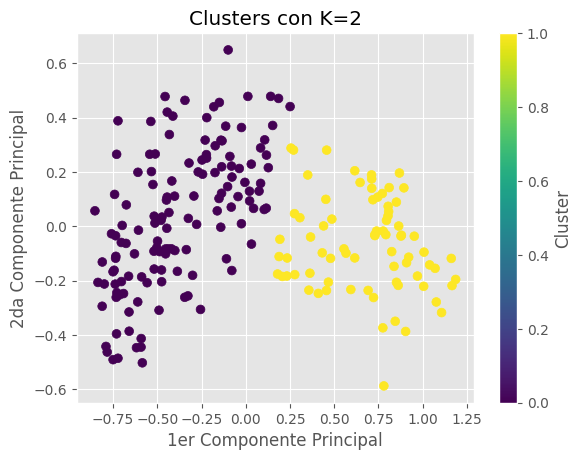

In [ ]:
# Entrenar el modelo con el mejor k
Jerárquico_Ajuste = AgglomerativeClustering(
    linkage='complete',
    n_clusters=2  # Asegúrate de tener el valor de k definido antes
)

# Ajustar el modelo
Jerárquico_Ajuste.fit(X_scaled)

# Obtener las etiquetas de los clusters (no se usa .predict())
y_predict = Jerárquico_Ajuste.labels_

# Visualizar los clusters en un gráfico 2D (si tienes PCA aplicado)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_predict, cmap='viridis', s=40)
plt.title(f'Clusters con K={2}')
plt.xlabel('1er Componente Principal')
plt.ylabel('2da Componente Principal')
plt.colorbar(label='Cluster')
plt.show()

Al igual que el modelo ajustado con K-Means, aquí podemos observar que el modelo ha dividido los datos a la mitad aunque no justo en el centro sino que tirando ligeramente a la derecha.

De todas formas, y al igual que pasa con K-Means, vemos que todos los datos están la zona de su cluster y no hay ningún dato en la zona de otro cluster.

#TÉCNICA DE CLUSTERING: DBSCAN

## ANÁLISIS INICIAL

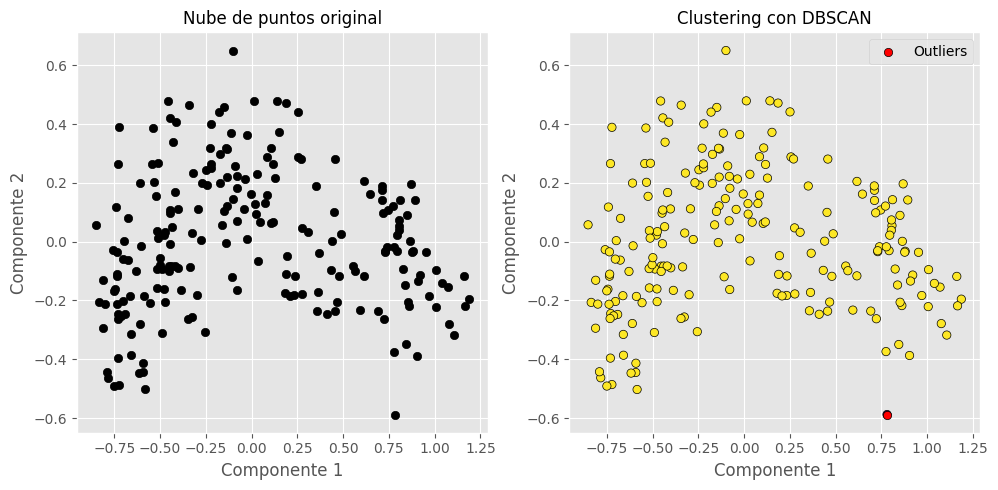

Número de clusters encontrados: 1
Número de outliers encontrados: 1


In [ ]:
# Entrenamiento del modelo DBSCAN
# ==============================================================================
DBSCAN_omision = DBSCAN(
    eps=0.2,
    min_samples=5,
    metric='euclidean'
)
DBSCAN_omision.fit(X_scaled)

# Etiquetas de cluster
labels = DBSCAN_omision.labels_

# Visualización en dos columnas
# ==============================================================================
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Nube de puntos original
axes[0].scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c='black',
    marker='o',
    edgecolor='black'
)
axes[0].set_title('Nube de puntos original', fontsize=12)
axes[0].set_xlabel('Componente 1')
axes[0].set_ylabel('Componente 2')

# Clustering con DBSCAN
scatter = axes[1].scatter(
    X_scaled[:, 0],
    X_scaled[:, 1],
    c=labels,
    marker='o',
    edgecolor='black'
)

# Resaltar outliers
axes[1].scatter(
    X_scaled[labels == -1, 0],
    X_scaled[labels == -1, 1],
    c='red',
    marker='o',
    edgecolor='black',
    label='Outliers'
)

axes[1].set_title('Clustering con DBSCAN', fontsize=12)
axes[1].set_xlabel('Componente 1')
axes[1].set_ylabel('Componente 2')
axes[1].legend()

plt.tight_layout()
plt.show()

# Información sobre los clusters
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Siguiendo el tutorial, auqnue poníendolo un poco más bonito, podemos llegar a una conclusión, DBSCAN no es una técnica de clustering adecuada en este caso.

DBSCAN no es adecuado ya que podemos observar visualmente que no hay una separación clara de los datos por zonas, todos están más o mejos juntos y tienen puntos que se conectan unos con otros, a excepción de un par de datos que pueden ser extremos y están más alejados del resto.

Por todo esto y antes de hacer el ajuste de hiperparámetros, podemos afirmar que DBSCAN no va a dar resultados adecuados.

## AJUSTE EPS

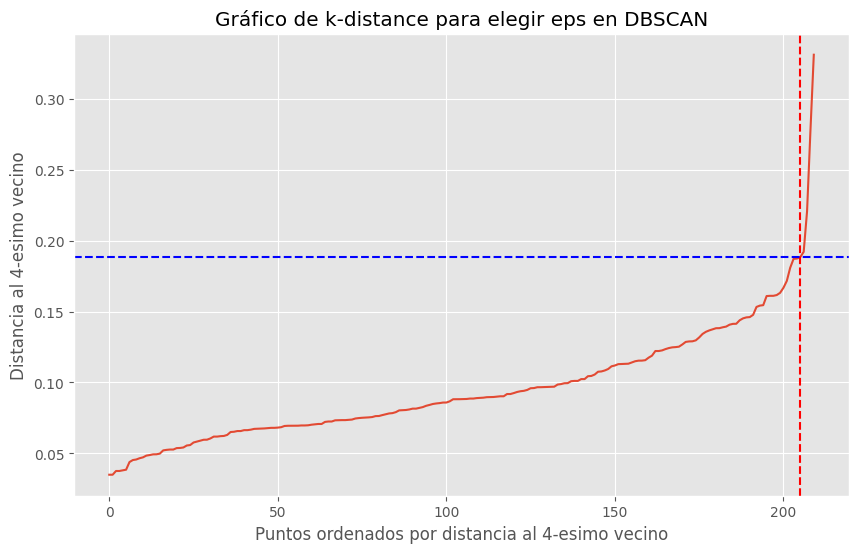

x_point=205 y_value=0.18837255813329845


In [ ]:
min_samples = 5

# Compute the nearest neighbors
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

# Sort the distances
sorted_distances = np.sort(distances[:, min_samples-1], axis=0)

x_point = 205
y_value = sorted_distances[x_point]  # Obtener el valor de la distancia para ese punto

# Plot the k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(sorted_distances)
plt.xlabel('Puntos ordenados por distancia al {}-esimo vecino'.format(min_samples-1))
plt.ylabel('Distancia al {}-esimo vecino'.format(min_samples-1))
plt.title('Gráfico de k-distance para elegir eps en DBSCAN')

plt.axvline(x=x_point, color='r', linestyle='--')

# Dibujar la línea horizontal correspondiente en el eje Y
plt.axhline(y=y_value, color='b', linestyle='--')

plt.grid(True)
plt.show()

print(f'{x_point=} y_value={y_value}')

Vemos que una eps de aproximadamente eps=0.18 corresponed al codo del gráfico anterior.

## DBSCAN AJUSTADO

Número de clusters encontrados: 1
Número de outliers encontrados: 2


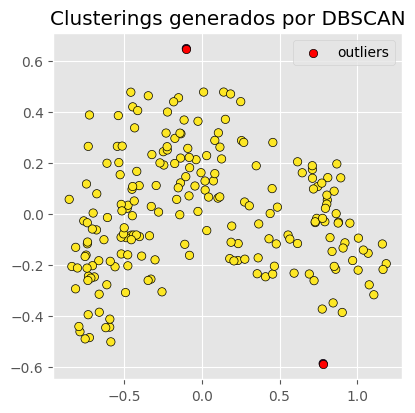

In [ ]:
# Modelo
# ==============================================================================
DBSCAN_ajuste = DBSCAN(
    eps          = y_value,
    min_samples  = 5,
    metric       = 'euclidean',
)

DBSCAN_ajuste.fit(X=X_scaled)

# Clasificación
# ==============================================================================
labels = DBSCAN_ajuste.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_scaled[labels == -1, 0],
    y = X_scaled[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN')

# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Como podemos observar nos salen los mismos datos que con el modelo sin ajustar, aunque en este caso nos sale dos 'outliers'.
Esto se debe a que todos los datos están muy juntos y pertenecen a un único cluster ya que no hay una separación obvia de dichos datos en varias zonas.

## DBSCAN AJUSTADO 2

Número de clusters encontrados: 3
Número de outliers encontrados: 20


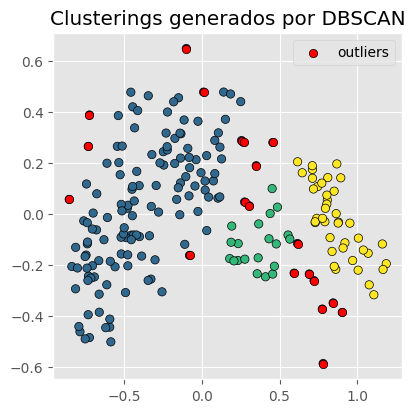

In [ ]:
# Modelo
# ==============================================================================
DBSCAN_ajuste = DBSCAN(
    eps          = y_value*0.65,
    min_samples  = 5,
    metric       = 'euclidean',
)

DBSCAN_ajuste.fit(X=X_scaled)

# Clasificación
# ==============================================================================
labels = DBSCAN_ajuste.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_scaled[labels == -1, 0],
    y = X_scaled[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN')

# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

A modo de comprobación, hemos decidido generar otro modelo pero reduciendo a un 65% el valor de 'y_value'.

Como podemos observar, haciendo este ajuste se nos generan 3 clusters pero dejamos 20 datos como outliers, es decir un 10% de los datos.

A pesar de que este modelo tiene mejor pinta que el anterior, al diferenciar 3 clusters en vez de establecer solo 1, creemos que una pérdida del 10% de los datos es excesivo, por eso no vamos a tener en cuenta este modelo.

# ANÁLISIS

## COMPROBACIÓN VISUAL DE LA MEJOR TÉCNICA DE CLUSTERING

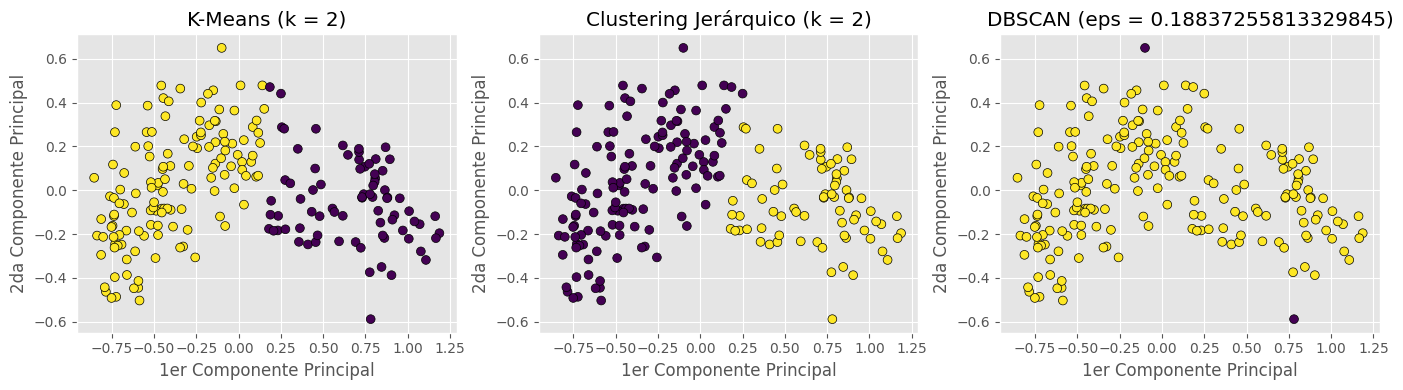

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# =========================
# K-Means
# =========================
kmeans_model = KMeans(
    n_clusters=2,
    init='k-means++',
    n_init=20,
    random_state=100496072
)
kmeans_model.fit(X_scaled)
labels_kmeans = kmeans_model.predict(X_scaled)

axes[0].scatter(
    X_scaled[:, 0], X_scaled[:, 1],
    c=labels_kmeans,
    cmap='viridis',
    s=40,
    edgecolor='black'
)
axes[0].set_title(f'K-Means (k = {2})')
axes[0].set_xlabel('1er Componente Principal')
axes[0].set_ylabel('2da Componente Principal')



# =========================
# Clustering Jerárquico
# =========================
hierarchical_model = AgglomerativeClustering(
    n_clusters=2,
    linkage='complete'
)
labels_hierarchical = hierarchical_model.fit_predict(X_scaled)

axes[1].scatter(
    X_scaled[:, 0], X_scaled[:, 1],
    c=labels_hierarchical,
    cmap='viridis',
    s=40,
    edgecolor='black'
)
axes[1].set_title(f'Clustering Jerárquico (k = {2})')
axes[1].set_xlabel('1er Componente Principal')
axes[1].set_ylabel('2da Componente Principal')



# =========================
# DBSCAN
# =========================
dbscan_model = DBSCAN(
    eps=y_value,
    min_samples=5,
    metric='euclidean'
)
labels_dbscan = dbscan_model.fit_predict(X_scaled)

axes[2].scatter(
    X_scaled[:, 0], X_scaled[:, 1],
    c=labels_dbscan,
    cmap='viridis',
    s=40,
    edgecolor='black'
)
axes[2].set_title(f'DBSCAN (eps = {y_value})')
axes[2].set_xlabel('1er Componente Principal')
axes[2].set_ylabel('2da Componente Principal')

plt.tight_layout()
plt.show()

Tras visualizar los 3 modelos el modelo que mejor nos parece es el generado por K-Means y que es el que hace una mejor 'separación' y 'agrupación' de los datos, aunque también podríamos haber escogido el modelo generado por Clustering Jerárquico.

Lo que está claro es que el modelo generado por DBSCAN es el peor de todos. Y que pese a haber modelos que parecen ajustar mejor los clusters, ninguno ha podido reproducir la realidad de los datos de entrada, que hay 3 tipos de semillas.

## ¿HAY RELACIÓN ENTRE LOS CLUSTERS OBTENIDOS Y LAS CLASES DE SEMILLAS ORIGINALES?

Esta pregunta es dificil de responder ya que originalmente la variable de respuesta 'clase' tenía 3 valores posibles y en caso de tener un modelo con 3 clusters podríamos hacer la comparación de una forma más precisa, al tener un modelo con dos clúster, es más complicado.

Aunque sea complicado tas hacer un análisis superficial hemos llegado a la siguiente conclusión: La mayoría de los datos con un valor de 1 en la variable 'clase' se han dispuesto en el cluster de la izquierda, la mayoría de los datos con un valor de 3 se han dispuesto en el cluster de la derecha y los que tenían un valor de 2 se han dispersado de forma similar entre los dos clusters.

## INTERPRETACIÓN DE LOS DATOS CON BOXPLOTS

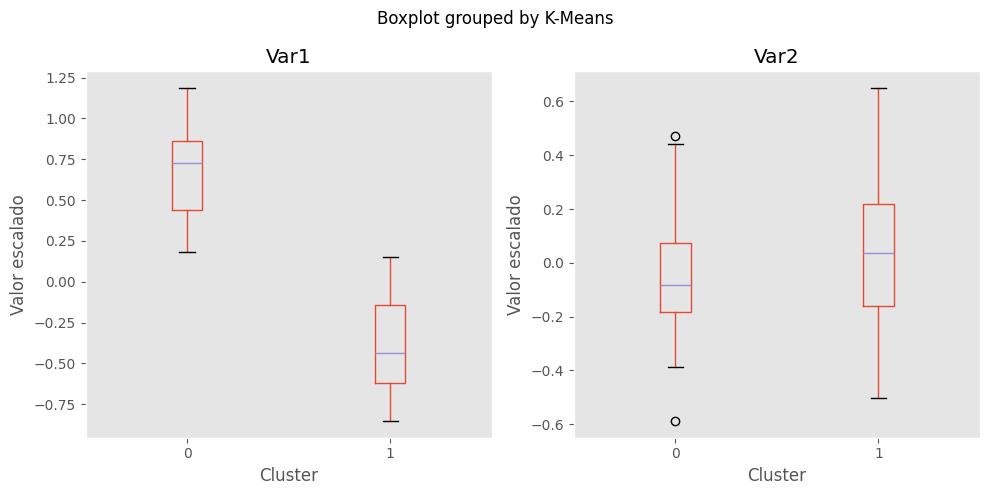

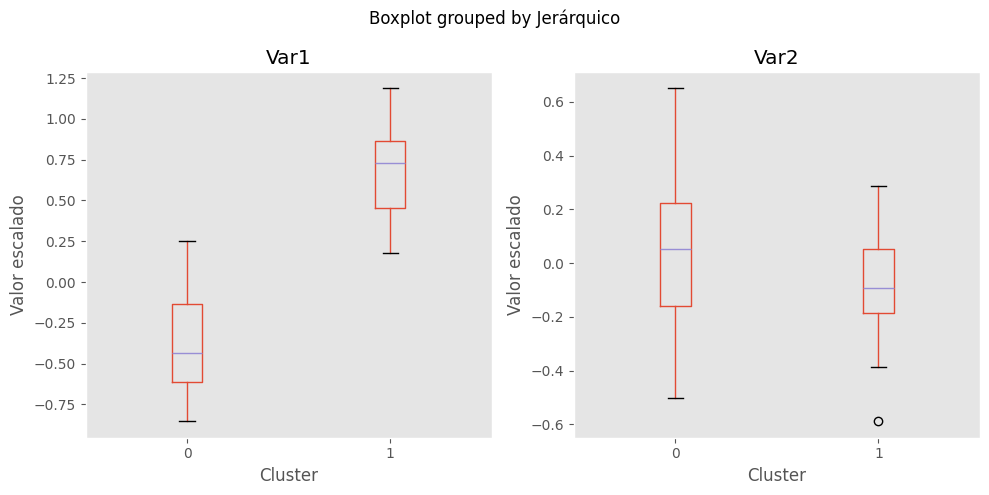

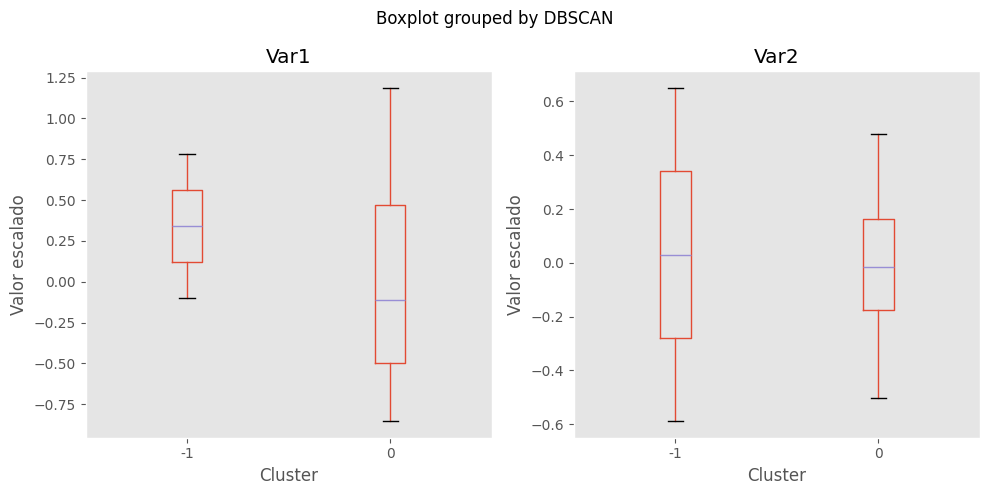

In [ ]:
X_df = pd.DataFrame(X_scaled, columns=["Var1", "Var2"])
X_df ["K-Means"] = KMeans(n_clusters=2, random_state=100496072).fit_predict(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, var in enumerate(["Var1", "Var2"]):
    X_df.boxplot(
        column=var,
        by="K-Means",
        ax=axes[i],
        grid=False
    )
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Valor escalado')

plt.tight_layout()
plt.show()


X_df = pd.DataFrame(X_scaled, columns=["Var1", "Var2"])
X_df ["Jerárquico"] = AgglomerativeClustering(n_clusters=2, linkage='complete').fit_predict(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, var in enumerate(["Var1", "Var2"]):
    X_df.boxplot(
        column=var,
        by="Jerárquico",
        ax=axes[i],
        grid=False
    )
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Valor escalado')

plt.tight_layout()
plt.show()


X_df = pd.DataFrame(X_scaled, columns=["Var1", "Var2"])
X_df ["DBSCAN"] = DBSCAN(eps=y_value, min_samples=5).fit_predict(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for i, var in enumerate(["Var1", "Var2"]):
    X_df.boxplot(
        column=var,
        by="DBSCAN",
        ax=axes[i],
        grid=False
    )
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Valor escalado')

plt.tight_layout()
plt.show()

Podemos observar que tanto para K-Means como para Clustering-Jerárquico, la Var1 tiene una mediana muy separada entre el cluster 0 y 1 lo cual nos indica que esa variable ayuda a identificar los grupos, cosa que tiene sentido tras lo visto en el apartado del PCA, mientras que las medianas de los cluters para Var2 son bastantes cercanas lo que nos indica que esa variable no ayuda mucho a diferenciar los grupos.

Por otro lado, podemos observar que para Var2 hay un par de outliers ("Casos Extremos") en alguno de los dos clusters.

Y como llevamos diciendo varios apartados, DBSCAN es el que tiene las peores métricas, define peor los boxplots y solapa más las disntintas clases.

# DECLARACIÓN DE USO DE LA IA

Se ha usado de forma selectiva y puntual para embellecer y esclarecer la estética de las gráficas, y para resolver errores que no hemos podido solucionar con los manuales o los tutoriales encontrados en la red.

** Cabe destacar que toda la parte gráfica y de impresión de datos y valores ha sido reformulada por parte de ChatGPT de cara a hacer la información más fácil de leer.
Esto se ha realizado con el previo consentimiento del profesor de prácticas.
Se puede revisar desde GitHub las versiones anteriores que contienen el código original sin refactorizar por parte de ChatGPT**

Además se ha hecho uso de la IA Gemini de Google, integrada en Google Colab para explicación de errores y autocompletado de código (supervisado).